In [5]:
import pandas as pd
import numpy as np
from  matplotlib import pyplot as plt
import networkx as nx

In [6]:

dfz = pd.read_parquet('dfz.parquet')
dfz_c= pd.read_parquet('dfz_c.parquet')
# Create the directed, weighted graph for base scenario from DataFrame
G = nx.from_pandas_adjacency(dfz, create_using=nx.DiGraph)
G_c = nx.from_pandas_adjacency(dfz_c, create_using=nx.DiGraph)

dfz_b = pd.read_parquet('dfz_bc.parquet')
dfz_b_c= pd.read_parquet('dfz_bc_c.parquet')
# Create the directed, weighted graph for bca scenario from DataFrame
G_b = nx.from_pandas_adjacency(dfz_b, create_using=nx.DiGraph)
G_b_c = nx.from_pandas_adjacency(dfz_b_c, create_using=nx.DiGraph)

In [ ]:
def sparsify_3pct_by_sector_inflow(G, threshold, weight_key='weight'):
    """
    Create a new DiGraph H where, for each buyer node v,
    we group its in-edges by the supplier sector and keep
    only those edges >= 3% of the total inflow from that sector.

    Assumes each node name looks like 'COUNTRY_SECTOR',
    e.g. 'FRA_MANche' or 'CHN_MANche'.
    """
    H = nx.DiGraph()

    # Iterate over each "buyer" node v
    for v in G.nodes():
        in_edges_data = G.in_edges(v, data=True)

        # 1) Sum flows by supplier sector 
        sector_in_sum = {}
        for (u, _, data) in in_edges_data:
            w = data.get(weight_key, 0.0)
            # Parse the supplier node's sector
            try:
                supplier_country, supplier_sector = u.split('_', 1)
            except ValueError:
                # If node naming doesn't match the pattern, skip or handle differently
                continue
            #what is setdefault doing?
            sector_in_sum.setdefault(supplier_sector, 0.0)
            sector_in_sum[supplier_sector] += w

        # 2) Keep edges above 3% threshold for each supplier sector
        for (u, _, data) in in_edges_data:
            w = data.get(weight_key, 0.0)
            try:
                supplier_country, supplier_sector = u.split('_', 1)
            except ValueError:
                continue

            total_for_sector = sector_in_sum.get(supplier_sector, 0.0)
            if total_for_sector > 0 and w >= threshold * total_for_sector:
                # Add this edge to H if it meets the criterion
                H.add_edge(u, v, **{weight_key: w})

    # 3) Check for nodes in H with all outgoing edges having zero weights
    for node in H.nodes():
        out_edges = list(H.out_edges(node, data=True))

        # Check if all outgoing edges have zero weight
        zero_weight_edges = [(u, v, data) for u, v, data in out_edges if data.get(weight_key, 0.0) == 0.0]
        if zero_weight_edges:  # Print only if not empty
            print(zero_weight_edges)
        if len(zero_weight_edges) == len(out_edges):  # All outgoing edges are zero-weight
            # For each zero-weight outgoing edge, find corresponding edges in G
            
            # Get all outgoing edges from ⁠ node ⁠ in the original graph ⁠ G ⁠
            outgoing_edges_in_G = G.out_edges(node, data=True)

            # Sort outgoing edges by weight in G (descending order)
            sorted_edges = sorted(outgoing_edges_in_G, key=lambda x: x[2].get(weight_key, 0.0), reverse=True)
    
            # Select the top 3 highest non-zero outgoing edges
            top_3_edges = [edge for edge in sorted_edges if edge[2].get(weight_key, 0.0) > 0.0][:3]

            # Replace the zero-weight edges in H with the top 3 corresponding edges
            for top_edge in top_3_edges:
                u, v, top_data = top_edge  # Unpack edge (u, v, data)

                # Now we find the corresponding edge in H and update its weight
                if H.has_edge(u, v): 
                    H[u][v][weight_key] = top_data.get(weight_key, 0.0)  # Substitute the weight
                else:
                    # If the edge doesn't exist in H, we add it (in case the edge wasn't added earlier)
                    H.add_edge(u, v, **{weight_key: top_data.get(weight_key, 0.0)})
    
  

    
    return H
# 1) Load your adjacency matrix from a parquet file (example: 'dfz.parquet')
dfz = pd.read_parquet('dfz.parquet')

# 2) Build a directed graph from the adjacency matrix
G = nx.from_pandas_adjacency(dfz, create_using=nx.DiGraph)

# 3) Apply the sector-based 3% inflow sparsification
H = sparsify_3pct_by_sector_inflow(G,0.03, weight_key='weight')

# 4) Convert the new graph H back to a DataFrame if you wish
dfz_sparsified = nx.to_pandas_adjacency(H, dtype=float)
dfz_sparsified.to_parquet('dfz_sparsified.parquet')

# Check how many edges remain
print(f"Original graph edges: {G.number_of_edges()}")
print(f"Sparsified graph edges: {H.number_of_edges()}")

Original graph edges: 4255969
Sparsified graph edges: 341160


In [53]:
import networkx as nx

def sparsify_3pct_by_sector_inflow(G, threshold, weight_key='weight'):
    """
    Create a new DiGraph H where, for each buyer node v,
    we group its in-edges by the supplier sector and keep
    only those edges >= threshold * (total inflow from that sector).

    Then, for each node, if the sum of its outgoing edges in H is
    less than 50% of the sum of its outgoing edges in G, we add
    the highest-weight outgoing edges from G until we reach >= 50%.

    Assumes each node name looks like 'COUNTRY_SECTOR',
    e.g. 'FRA_MANche' or 'CHN_MANche'.
    """
    H = nx.DiGraph()

    # --- 1) Keep edges >= threshold * sector inflow ---
    for v in G.nodes():
        # All in-edges to v
        in_edges_data = G.in_edges(v, data=True)

        # 1A) Sum flows by supplier sector
        sector_in_sum = {}
        for (u, _, data) in in_edges_data:
            w = data.get(weight_key, 0.0)
            try:
                # Split "FRA_MANche" into "FRA" and "MANche"
                supplier_country, supplier_sector = u.split('_', 1)
            except ValueError:
                # If node naming doesn't match, skip or handle differently
                continue
            sector_in_sum.setdefault(supplier_sector, 0.0)
            sector_in_sum[supplier_sector] += w

        # 1B) Keep only edges >= threshold * total_for_that_sector
        for (u, _, data) in in_edges_data:
            w = data.get(weight_key, 0.0)
            try:
                supplier_country, supplier_sector = u.split('_', 1)
            except ValueError:
                continue

            total_for_sector = sector_in_sum.get(supplier_sector, 0.0)
            if total_for_sector > 0 and w >= threshold * total_for_sector:
                # Add edge to H
                H.add_edge(u, v, **{weight_key: w})

    # --- 2) Ensure each node's outgoing edges in H reach >= 50% of G's total ---
    for node in H.nodes():
        # 2A) Sum of outgoing edges in H
        out_edges_H = H.out_edges(node, data=True)
        sum_H = sum(data.get(weight_key, 0.0) for _, _, data in out_edges_H)

        # 2B) Sum of outgoing edges in G
        out_edges_G = G.out_edges(node, data=True)
        sum_G = sum(data.get(weight_key, 0.0) for _, _, data in out_edges_G)

        # 2C) If < 50%, add highest-weight edges from G until we reach >= 50%
        if sum_G > 0:
            ratio = sum_H / sum_G
            if ratio < 0.5:
                # Sort G's outgoing edges (descending by weight)
                sorted_out_edges = sorted(
                    out_edges_G,
                    key=lambda x: x[2].get(weight_key, 0.0),
                    reverse=True
                )
                # Add edges from G until ratio >= 0.5 (or no more edges)
                for u, v, data in sorted_out_edges:
                    w_g = data.get(weight_key, 0.0)
                    if w_g <= 0:
                        continue  # Skip zero-weight edges

                    # If H doesn't have this edge or has a smaller weight, update it
                    if H.has_edge(u, v):
                        current_w = H[u][v].get(weight_key, 0.0)
                    else:
                        current_w = 0.0

                    if current_w < w_g:
                        # Add/update in H
                        H.add_edge(u, v, **{weight_key: w_g})
                        # Update sum_H and check ratio
                        sum_H = sum_H - current_w + w_g
                        ratio = sum_H / sum_G
                        if ratio >= 0.5:
                            break

    return H
# 1) Load your adjacency matrix from a parquet file (example: 'dfz.parquet')
dfz = pd.read_parquet('dfz.parquet')

# 2) Build a directed graph from the adjacency matrix
G = nx.from_pandas_adjacency(dfz, create_using=nx.DiGraph)

# 3) Apply the sector-based 3% inflow sparsification
H = sparsify_3pct_by_sector_inflow(G,0.03, weight_key='weight')

# 4) Convert the new graph H back to a DataFrame if you wish
dfz_sparsified = nx.to_pandas_adjacency(H, dtype=float)
dfz_sparsified.to_parquet('dfz_sparsified.parquet')

# Check how many edges remain
print(f"Original graph edges: {G.number_of_edges()}")
print(f"Sparsified graph edges: {H.number_of_edges()}")

Original graph edges: 4255969
Sparsified graph edges: 343382


In [54]:
# Get the Boolean mask of all rows where "AUS_AGRagr" != 0
mask = dfz_sparsified["AUS_AGRagr"] != 0

# Extract and explicitly print each index
nonzero_indices = dfz_sparsified.index[mask]

# Explicitly print every index value
for idx in nonzero_indices:
    print(idx)

AUS_AGRagr
AUS_AGRfor
AUS_AGRfis
AUS_ENRcoa
AUS_ENRoil
AUS_ENRgas
AUS_MIN+
AUS_MANfoo
AUS_MANtex
AUS_MANwoo
AUS_MANpap
AUS_MANpri
AUS_MANche
AUS_MANpha
AUS_MANpla
AUS_MANmin
AUS_MANmet
AUS_MANfmp
AUS_MANmac
AUS_MANmot
AUS_MANtra
AUS_MANrep
AUS_MANcom
AUS_MANele
AUS_MANfur
AUS_ENRele
AUS_WATwat
AUS_WATwst
AUS_CNS+
AUS_TRDmot
AUS_TRAinl
AUS_TRAwat
AUS_TRAair
AUS_TRAwar
AUS_TRApos
AUS_FD+
AUS_COMpub
AUS_COMvid
AUS_COMcom
AUS_FINser
AUS_RES+
AUS_PROleg
AUS_ADM+
AUS_PUB+
AUS_EDU+
AUS_HEA+
AUS_ART+
AUS_EXT+
CHE_MANpha
CHN_MANtex
CHN_MANwoo
CHN_MANpap
CHN_MANche
CHN_MANpha
CHN_MANpla
CHN_MANfmp
CHN_MANmac
CHN_MANtra
CHN_MANcom
CHN_MANele
DEU_MANpha
DEU_MANmac
DEU_MANmot
DEU_MANele
GBR_MANpri
GBR_COMpub
IND_MANtex
IRL_MANpha
IRL_MANcom
IRL_COMpub
ITA_MANmac
ITA_MANmot
JPN_ENRoil
JPN_MANmet
JPN_MANmac
JPN_MANmot
JPN_EDU+
KOR_ENRoil
KOR_MANche
NLD_COMcom
USA_ENRoil
USA_MANpri
USA_MANche
USA_MANpha
USA_MANmac
USA_MANtra
USA_MANele
USA_COMpub
USA_COMvid
USA_HEA+
RoW_AGRfor
RoW_COMpub
RoW_COMvid
Ro

In [55]:
dfz.groupby(dfz.index.str[4:]).sum().head(20)

,AUS_AGRagr,AUS_AGRfor,AUS_AGRfis,AUS_ENRcoa,AUS_ENRoil,AUS_ENRgas,AUS_MIN+,AUS_MANfoo,AUS_MANtex,AUS_MANwoo,...,RoW_PROleg,RoW_PUB+,RoW_RES+,RoW_TRAair,RoW_TRAinl,RoW_TRApos,RoW_TRAwar,RoW_TRDmot,RoW_WATwat,RoW_WATwst
ADM+,1.243157e+06,8.974516e+04,2.972949e+05,5.592646e+05,4.897077e+05,7.886441e+05,1.482045e+06,2.262268e+06,114407.858220,4.271686e+05,...,1.262466e+07,1.454973e+07,8.405106e+06,4.133101e+06,7.760062e+06,9.039300e+05,4.072011e+06,2.682635e+07,1.345515e+06,9.172115e+05
AGRagr,6.761164e+06,1.177193e+02,1.039974e+06,8.516663e+02,1.120645e+02,2.625330e+02,5.226812e+03,2.406346e+07,636490.848701,1.516227e+03,...,1.240082e+06,6.110884e+06,8.661052e+05,1.811122e+06,6.615561e+05,3.323903e+04,3.211289e+05,3.188903e+07,1.774202e+05,1.387446e+05
AGRfis,5.698236e+05,7.618359e+01,1.384151e+05,7.642641e+03,2.501458e+03,5.291630e+03,2.006449e+04,2.186002e+06,55923.709753,7.156566e+02,...,1.001671e+05,5.264910e+05,6.930310e+04,1.922964e+05,4.277546e+04,5.439368e+03,4.874078e+04,9.092409e+05,1.991339e+03,1.957358e+04
AGRfor,1.835082e+05,1.505525e+06,1.489388e+01,3.327155e+04,7.897952e+03,1.029486e+00,1.102226e+05,3.703336e+02,0.226147,1.354877e+06,...,5.570438e+03,9.483653e+03,1.965561e+03,7.023482e+03,2.753899e+03,1.585574e+02,1.169830e+03,3.318334e+04,2.573725e+01,3.691037e+02
ART+,2.001359e+04,1.730665e+03,6.892949e+03,5.499734e+04,2.593790e+04,2.378022e+04,8.890238e+04,2.228254e+04,1092.203789,3.147801e+03,...,1.009292e+06,1.641454e+06,4.611863e+05,1.008415e+05,2.657921e+05,5.960282e+04,1.620294e+05,1.323446e+06,3.270799e+04,3.503979e+04
CNS+,2.494347e+06,1.666515e+03,1.993211e+05,9.441427e+05,1.254560e+06,4.076527e+05,4.905904e+06,3.995447e+05,25462.717918,7.702126e+05,...,4.533538e+06,1.689037e+07,2.404706e+07,1.024918e+06,4.300746e+06,1.860631e+05,2.820060e+06,7.618318e+06,1.125968e+06,9.806068e+05
COMcom,9.241179e+04,7.164762e+02,1.426117e+04,1.488610e+05,2.604534e+04,2.175759e+04,1.771510e+05,2.476188e+05,19787.980590,7.276269e+04,...,3.978150e+06,8.254448e+06,1.385040e+06,6.512649e+05,1.090895e+06,3.920075e+05,9.399348e+05,7.485501e+06,2.660621e+05,1.634616e+05
COMpub,3.852497e+04,7.716919e+01,7.409698e+03,2.995957e+03,5.734403e+03,4.179215e+04,4.588145e+04,8.498852e+04,4877.041716,1.901674e+04,...,1.045467e+07,4.265711e+06,1.649834e+06,7.112787e+05,1.214506e+06,2.213981e+05,9.355037e+05,1.195183e+07,1.504696e+05,8.057544e+04
COMvid,1.062374e+05,5.600009e+01,1.675526e+04,3.011001e+04,1.398170e+05,7.918445e+04,1.013551e+05,1.937182e+05,7350.761434,6.796873e+04,...,7.667938e+06,8.537668e+06,5.428859e+06,8.279746e+05,3.238752e+06,7.308839e+05,1.384803e+06,1.742748e+07,2.885567e+05,2.066017e+05
EDU+,2.344206e+04,4.117248e+01,3.043110e+03,2.358781e+04,3.261954e+04,1.651048e+04,7.016169e+04,4.332651e+04,2690.426105,8.253520e+03,...,1.808740e+06,5.732795e+06,6.822197e+05,2.044877e+05,5.450891e+05,7.643737e+04,4.114855e+05,2.523897e+06,9.530611e+04,5.195074e+04


In [56]:
max_column_name = dfz.loc['CYP_MANcom'].idxmax()
max_value = dfz.loc['CYP_MANcom', max_column_name]

print(f"Column with the greatest value: {max_column_name}")
print(f"Greatest value: {max_value}")
print(dfz.loc['CYP_MANcom', 'CYP_MANrep'])

Column with the greatest value: GRC_TRDmot
Greatest value: 630.027956453707
0.389315687565305


In [57]:
# Get non-zero columns for 'CYP_MANcom'
nonzero_columns_CYP_MANcom = dfz_sparsified.columns[dfz_sparsified.loc['CYP_MANcom'] != 0]
print("Non-zero columns for CYP_MANcom:")
for col in nonzero_columns_CYP_MANcom:
    print(col)

# Get non-zero columns for 'LUX_ENRoil'
nonzero_columns_LUX_ENRoil = dfz_sparsified.columns[dfz_sparsified.loc['LUX_ENRoil'] != 0]
print("\nNon-zero columns for LUX_ENRoil:")
for col in nonzero_columns_LUX_ENRoil:
    print(col)

Non-zero columns for CYP_MANcom:
RoW_MANcom
RoW_TRDmot
RoW_PUB+
GBR_HEA+
CHE_MANcom
DEU_MANcom
RoW_CNS+
HUN_MANcom
NLD_MANcom
NLD_MANmac
GRC_COMpub
GRC_EDU+
GRC_ENRele
GRC_TRDmot
ITA_MANcom
GRC_MANfoo
GRC_MANcom
ROU_MANcom
CYP_MANrep
GRC_PROleg
GRC_ADM+
GBR_PUB+
ROU_HEA+

Non-zero columns for LUX_ENRoil:
IDN_ENRgas
IND_ENRcoa
LUX_AGRfis


In [58]:
# 1) Sum across columns for each row
row_sums_dfz_sparsified = dfz_sparsified.sum(axis=1)
row_sums_dfz = dfz.sum(axis=1)

# 2) Compute the ratio of row sums
ratios = row_sums_dfz_sparsified / row_sums_dfz  # elementwise division

print(ratios.mean())
# 3) Sort ascending and print the lowest 20
lowest_20 = ratios.nsmallest(100)
for idx, ratio in lowest_20.items():
    print(f"{idx}: {ratio:.2%}")

0.8145084855995937
BEL_MANele: 50.00%
SVK_MANpha: 50.00%
EST_MANpap: 50.01%
FIN_MANfur: 50.01%
HUN_MANmac: 50.01%
SVN_MANfur: 50.02%
CHE_COMpub: 50.03%
LUX_MANrep: 50.03%
LTU_MANfur: 50.03%
MLT_COMpub: 50.03%
HUN_MANele: 50.03%
DNK_TRAwar: 50.04%
MLT_MANtex: 50.05%
SVN_TRAair: 50.06%
BEL_MANpla: 50.07%
SWE_MANele: 50.07%
LTU_MANmac: 50.07%
GRC_TRAair: 50.08%
SWE_MANmet: 50.08%
BGR_MANpha: 50.09%
SVK_MANcom: 50.09%
SVK_MANfur: 50.10%
LVA_ENRgas: 50.10%
HRV_MANche: 50.10%
LUX_MANfur: 50.10%
LTU_MANmet: 50.10%
SVK_MANpla: 50.11%
ROU_MANmac: 50.11%
IRL_MANele: 50.11%
SVN_MANele: 50.11%
RUS_MANpri: 50.12%
SWE_MANmot: 50.13%
PRT_MANmot: 50.13%
IRL_MANmac: 50.14%
HUN_MANfur: 50.14%
BGR_MANfur: 50.16%
LVA_TRAair: 50.16%
HRV_MANfur: 50.17%
CZE_MANpha: 50.17%
SWE_MANpla: 50.17%
NLD_MANmet: 50.18%
EST_MANfur: 50.18%
LTU_MANfoo: 50.18%
HUN_MANfmp: 50.19%
SVN_MANtra: 50.19%
CHE_MANfur: 50.19%
CHE_MANche: 50.20%
LTU_MANpha: 50.21%
SWE_TRAair: 50.21%
GRC_MANche: 50.21%
SVK_MANpap: 50.22%
BGR_TRAwat: 

In [59]:
import pandas as pd
import numpy as np

ratios_list = []

# Loop over each column in dfz_sparsified (assuming dfz has the same columns)
for col in dfz_sparsified.columns:
    # 1) Group and sum in dfz
    s1 = dfz.groupby(dfz.index.str[4:])[col].sum()

    # 2) Group and sum in dfz_sparsified
    s2 = dfz_sparsified.groupby(dfz_sparsified.index.str[4:])[col].sum()

    # 3) Compute the ratio
    ratio = s2 / s1  # Will be NaN or Inf if s1=0

    # Convert to DataFrame so we can keep track of column + group
    col_ratio_df = pd.DataFrame({
        'group': ratio.index,
        'ratio': ratio.values
    })
    col_ratio_df['column'] = col

    # Accumulate in a list
    ratios_list.append(col_ratio_df)

# 4) Combine all per-column DataFrames
all_ratios_df = pd.concat(ratios_list, ignore_index=True)

# 5) Drop NaN or infinite values (which happen if s1=0 or ratio is undefined)
all_ratios_df.replace([np.inf, -np.inf], np.nan, inplace=True)
all_ratios_df.dropna(subset=['ratio'], inplace=True)

# 6) Sort ascending by ratio
all_ratios_df.sort_values('ratio', ascending=True, inplace=True)

# 7) Print the lowest 20
lowest_20 = all_ratios_df.head(20)
print(lowest_20)

        group     ratio      column
27544  TRAair  0.610573  DEU_FINser
43625  TRAinl  0.614242    GRC_EDU+
98088  MANmac  0.618668    ROU_EDU+
5594   MANmin  0.625045  AUT_ENRcoa
86636  TRAwat  0.629998  SVN_TRDmot
58100  MANele  0.632970  SWE_MANcom
39188  MANele  0.633825  BEL_ENRgas
70915  MANcom  0.637165  EST_ENRcoa
44633  TRAinl  0.641884  NOR_MANfur
32968  TRAair  0.645327  ROU_TRAinl
28888  TRAair  0.647352  DEU_COMvid
70073  TRAinl  0.648723    CYP_EXT+
93737  TRAinl  0.652197  MLT_TRAinl
24308  MANele  0.652199  SWE_MANfur
37032  MANmac  0.653315  POL_MANele
81438  MANpla  0.656788    FIN_ADM+
97720  TRAair  0.657551  ROU_MANfmp
9017   TRAinl  0.657588  DEU_MANfur
61175  MANfur  0.657940    DEU_RES+
31848  MANmac  0.658621    POL_EXT+


In [33]:
# 1) Group and sum in dfz
s1 = dfz.groupby(dfz.index.str[4:])["AUS_MANpla"].sum()

# 2) Group and sum in dfz_sparsified
s2 = dfz_sparsified.groupby(dfz_sparsified.index.str[4:])["AUS_MANpla"].sum()

# 3) Divide elementwise
ratio =  s2/s1

# 4) Print the ratio for each index
print(ratio)

ADM+      0.953332
AGRagr    0.975576
AGRfis    0.995275
AGRfor    0.997368
ART+      0.918035
CNS+      0.995269
COMcom    0.940001
COMpub    0.924777
COMvid    0.972591
EDU+      0.978617
ENRcoa    0.933595
ENRele    0.999912
ENRgas    0.983114
ENRoil    0.914747
EXT+      0.990012
FD+       0.995315
FINser    0.957750
HEA+      0.951033
MANche    0.791801
MANcom    0.854226
MANele    0.841292
MANfmp    0.944882
MANfoo    0.900624
MANfur    0.889495
MANmac    0.857401
MANmet    0.913598
MANmin    0.922825
MANmot    0.815878
MANpap    0.887595
MANpha    0.940523
MANpla    0.850109
MANpri    0.965773
MANrep    1.000000
MANtex    0.907005
MANtra    0.955226
MANwoo    0.893879
MIN+      0.964669
PROleg    0.951920
PUB+      0.994947
RES+      0.989223
TRAair    0.916231
TRAinl    0.914056
TRApos    0.987378
TRAwar    0.940392
TRAwat    0.956174
TRDmot    0.919187
WATwat    1.000000
WATwst    0.984985
Name: AUS_MANpla, dtype: float64


In [28]:
# For dfz
print(dfz.groupby(dfz.index.str[4:])["AUS_AGRagr"].sum())

# For dfz_sparsified
print(dfz_sparsified.groupby(dfz_sparsified.index.str[4:])["AUS_AGRagr"].sum())

ADM+      1.243157e+06
AGRagr    6.761164e+06
AGRfis    5.698236e+05
AGRfor    1.835082e+05
ART+      2.001359e+04
CNS+      2.494347e+06
COMcom    9.241179e+04
COMpub    3.852497e+04
COMvid    1.062374e+05
EDU+      2.344206e+04
ENRcoa    9.870834e+03
ENRele    7.217270e+05
ENRgas    2.334622e+05
ENRoil    1.676788e+06
EXT+      7.056844e+04
FD+       2.627911e+05
FINser    4.950917e+06
HEA+      9.230361e+03
MANche    7.845118e+05
MANcom    7.571524e+04
MANele    7.310682e+04
MANfmp    1.521998e+05
MANfoo    1.262683e+06
MANfur    4.467183e+04
MANmac    4.772703e+05
MANmet    4.592352e+04
MANmin    1.744547e+04
MANmot    4.343415e+04
MANpap    8.045388e+04
MANpha    1.966981e+06
MANpla    1.122841e+05
MANpri    1.066010e+04
MANrep    5.406398e+04
MANtex    8.671504e+04
MANtra    6.044959e+04
MANwoo    3.337132e+04
MIN+      1.463226e+05
PROleg    2.628141e+06
PUB+      9.274403e+04
RES+      6.145408e+05
TRAair    1.370037e+05
TRAinl    1.156555e+06
TRApos    1.258937e+05
TRAwar    1

In [24]:
print(dfz.groupby(dfz.columns.str[-6:])["AUS_AGRagr"].sum())
print(dfz_sparsified.groupby(dfz.columns.str[-6:])["AUS_AGRagr"].sum())


AGRagr    6.761164e+06
AGRfis    5.698236e+05
AGRfor    1.835082e+05
AN_FD+    3.619601e+01
A_ADM+    4.314740e+01
              ...     
X_PUB+    4.202950e-02
X_RES+    3.484755e+00
YP_FD+    3.048770e+00
ZE_FD+    2.084939e+00
oW_FD+    1.290546e+03
Name: AUS_AGRagr, Length: 213, dtype: float64
AGRagr    6.656075e+06
AGRfis    5.760772e+05
AGRfor    2.294544e+05
AN_FD+    0.000000e+00
A_ADM+    0.000000e+00
              ...     
X_PUB+    0.000000e+00
X_RES+    0.000000e+00
YP_FD+    0.000000e+00
ZE_FD+    0.000000e+00
oW_FD+    0.000000e+00
Name: AUS_AGRagr, Length: 213, dtype: float64


In [20]:
import networkx as nx

def sparsify_3pct_by_sector_inflow(G, weight_key='weight'):
    """
    Create a new DiGraph H where, for each buyer node v,
    we group its in-edges by the supplier sector and keep
    only those edges >= 3% of the total inflow from that sector.

    Assumes each node name looks like 'COUNTRY_SECTOR',
    e.g. 'FRA_MANche' or 'CHN_MANche'.
    """
    H = nx.DiGraph()

    # Iterate over each "buyer" node v
    for v in G.nodes():
        in_edges_data = G.in_edges(v, data=True)

        # 1) Sum flows by supplier sector
        sector_in_sum = {}
        for (u, _, data) in in_edges_data:
            w = data.get(weight_key, 0.0)
            # Parse the supplier node's sector
            try:
                supplier_country, supplier_sector = u.split('_', 1)
            except ValueError:
                # If node naming doesn't match the pattern, skip or handle differently
                continue
            
            sector_in_sum.setdefault(supplier_sector, 0.0)
            sector_in_sum[supplier_sector] += w

        # 2) Keep edges above 3% threshold for each supplier sector
        for (u, _, data) in in_edges_data:
            w = data.get(weight_key, 0.0)
            try:
                supplier_country, supplier_sector = u.split('_', 1)
            except ValueError:
                continue

            total_for_sector = sector_in_sum.get(supplier_sector, 0.0)
            if total_for_sector > 0 and w >= 0.03 * total_for_sector:
                # Add this edge to H if it meets the criterion
                H.add_edge(u, v, **{weight_key: w})

    return H


# -----------------------------
# EXAMPLE USAGE
# -----------------------------
import pandas as pd

# 1) Load your adjacency matrix from a parquet file (example: 'dfz.parquet')
dfz = pd.read_parquet('dfz.parquet')

# 2) Build a directed graph from the adjacency matrix
G = nx.from_pandas_adjacency(dfz, create_using=nx.DiGraph)

# 3) Apply the sector-based 3% inflow sparsification
H = sparsify_3pct_by_sector_inflow(G, weight_key='weight')

# 4) Convert the new graph H back to a DataFrame if you wish
dfz_sparsified = nx.to_pandas_adjacency(H, dtype=float)
dfz_sparsified.to_parquet('dfz_sparsified.parquet')

# Check how many edges remain
print(f"Original graph edges: {G.number_of_edges()}")
print(f"Sparsified graph edges: {H.number_of_edges()}")

Original graph edges: 4255969
Sparsified graph edges: 341154


In [22]:
print(dfz.groupby(dfz.columns.str[-6:])["AUS_AGRagr"].sum())
print(dfz_sparsified.groupby(dfz.columns.str[-6:])["AUS_AGRagr"].sum())


AGRagr    6.761164e+06
AGRfis    5.698236e+05
AGRfor    1.835082e+05
AN_FD+    3.619601e+01
A_ADM+    4.314740e+01
              ...     
X_PUB+    4.202950e-02
X_RES+    3.484755e+00
YP_FD+    3.048770e+00
ZE_FD+    2.084939e+00
oW_FD+    1.290546e+03
Name: AUS_AGRagr, Length: 213, dtype: float64
AGRagr    6.656075e+06
AGRfis    5.760772e+05
AGRfor    2.294544e+05
AN_FD+    0.000000e+00
A_ADM+    0.000000e+00
              ...     
X_PUB+    0.000000e+00
X_RES+    0.000000e+00
YP_FD+    0.000000e+00
ZE_FD+    0.000000e+00
oW_FD+    0.000000e+00
Name: AUS_AGRagr, Length: 213, dtype: float64


In [8]:
dfz.head()

,AUS_AGRagr,AUS_AGRfor,AUS_AGRfis,AUS_ENRcoa,AUS_ENRoil,AUS_ENRgas,AUS_MIN+,AUS_MANfoo,AUS_MANtex,AUS_MANwoo,...,RoW_PROleg,RoW_PUB+,RoW_RES+,RoW_TRAair,RoW_TRAinl,RoW_TRApos,RoW_TRAwar,RoW_TRDmot,RoW_WATwat,RoW_WATwst
AUS_AGRagr,6.569054e+06,2.432542e+01,1.020061e+06,17.057121,5.768301e-02,0.000471,3.615918e+03,2.366996e+07,622891.339145,9.619917e-06,...,4076.929925,10212.057170,3042.188308,51828.265914,7326.157788,503.724292,1974.925657,44162.158332,637.164857,512.059988
AUS_AGRfor,1.289110e+05,1.484102e+06,2.180136e-02,33269.792128,7.897181e+03,0.000043,1.078534e+05,4.223909e-05,0.000015,1.313020e+06,...,7.406042,7.033078,1.284265,0.526782,0.186846,0.045285,2.269817,5.714477,0.002067,0.006443
AUS_AGRfis,5.669242e+05,1.813493e-02,1.375585e+05,7432.630865,2.428477e+03,5165.035462,1.965175e+04,2.164037e+06,55455.755698,7.004979e+02,...,539.847466,808.411878,255.070810,6440.856973,787.984044,66.882612,238.744950,2859.943454,15.199208,198.593245
AUS_ENRcoa,1.222611e+03,6.895820e-05,2.002838e-04,70768.029463,2.075179e-06,0.000008,8.513631e+04,3.249412e+04,5445.536518,6.850711e-03,...,3279.124447,4515.543552,1049.281917,2263.453997,16423.691539,668.566758,43258.394537,31979.457778,615.089457,1992.180745
AUS_ENRoil,4.876918e+05,2.019541e+05,2.463233e+05,900906.253367,3.784528e+06,77174.779871,1.524484e+06,8.593024e+04,5195.714704,1.324390e+04,...,3011.646167,6381.546592,3030.535988,40105.905310,35197.989224,1146.562081,61241.794726,67157.157094,1131.337123,440.049656


In [15]:
print(dfz.columns)

Index(['AUS_AGRagr', 'AUS_AGRfor', 'AUS_AGRfis', 'AUS_ENRcoa', 'AUS_ENRoil',
       'AUS_ENRgas', 'AUS_MIN+', 'AUS_MANfoo', 'AUS_MANtex', 'AUS_MANwoo',
       ...
       'RoW_PROleg', 'RoW_PUB+', 'RoW_RES+', 'RoW_TRAair', 'RoW_TRAinl',
       'RoW_TRApos', 'RoW_TRAwar', 'RoW_TRDmot', 'RoW_WATwat', 'RoW_WATwst'],
      dtype='object', length=2063)


In [18]:
print(dfz.groupby(dfz.columns.str[-6:])["AUS_AGRagr"].sum())
print(dfz_sparsified.groupby(dfz.columns.str[-6:])["AUS_AGRagr"].sum())


AGRagr    6.761164e+06
AGRfis    5.698236e+05
AGRfor    1.835082e+05
AN_FD+    3.619601e+01
A_ADM+    4.314740e+01
              ...     
X_PUB+    4.202950e-02
X_RES+    3.484755e+00
YP_FD+    3.048770e+00
ZE_FD+    2.084939e+00
oW_FD+    1.290546e+03
Name: AUS_AGRagr, Length: 213, dtype: float64
AGRagr    6.656075e+06
AGRfis    5.760772e+05
AGRfor    2.294544e+05
AN_FD+    0.000000e+00
A_ADM+    0.000000e+00
              ...     
X_PUB+    0.000000e+00
X_RES+    0.000000e+00
YP_FD+    0.000000e+00
ZE_FD+    0.000000e+00
oW_FD+    0.000000e+00
Name: AUS_AGRagr, Length: 213, dtype: float64


In [ ]:
dfz_sparsified.head()

,AUS_AGRagr,AUS_AGRfor,AUS_AGRfis,AUS_ENRcoa,AUS_ENRoil,AUS_ENRgas,AUS_MIN+,AUS_MANfoo,AUS_MANtex,AUS_MANwoo,...,SVN_MANrep,SVN_FINser,SVN_RES+,SWE_RES+,TUR_AGRfis,TUR_MANrep,TUR_COMvid,TUR_COMcom,TUR_PROleg,TUR_HEA+
AUS_AGRagr,6.569054e+06,2.432542e+01,1.020061e+06,0.000000,0.000000e+00,0.000000,3.615918e+03,2.366996e+07,622891.339145,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
AUS_AGRfor,1.289110e+05,1.484102e+06,0.000000e+00,33269.792128,7.897181e+03,0.000000,1.078534e+05,0.000000e+00,0.000000,1.313020e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
AUS_AGRfis,5.669242e+05,0.000000e+00,1.375585e+05,7432.630865,2.428477e+03,5165.035462,1.965175e+04,2.164037e+06,55455.755698,7.004979e+02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.518359,0.077805,0.0,0.0
AUS_ENRcoa,1.222611e+03,0.000000e+00,0.000000e+00,70768.029463,0.000000e+00,0.000000,8.513631e+04,3.249412e+04,5445.536518,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
AUS_ENRoil,4.876918e+05,2.019541e+05,2.463233e+05,900906.253367,3.784528e+06,77174.779871,1.524484e+06,8.593024e+04,5195.714704,1.324390e+04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


In [45]:
# ---------------------------------------------------
# Define a function to compute the symmetry index S
# ---------------------------------------------------
def symmetry_index(G):
    """
    Compute the symmetry index S for a directed, weighted graph G.
    
    According to Fagiolo (2007), one first defines:
    
        S̃(A) = ||A - Aᵀ||²_F / (2 * ||A||²_F)
        
    where A is the weighted adjacency matrix with its diagonal set to 1.
    Then, the rescaled symmetry index is:
    
        S(A) = ((N + 1) / (N - 1)) * S̃(A)
        
    If the values of the matrix are not in the interval [0, 1],
    the matrix is normalized by dividing by its maximum value.
    """
    # Get the weighted adjacency matrix as a NumPy array
    A = nx.to_numpy_array(G)
    np.fill_diagonal(A, 1)

    # Set the diagonal entries to 1 (as required by the paper)
    # If any value is not in [0, 1], normalize the entire matrix
    if (A < 0).any() or (A > 1).any():
        max_val = A.max()
        if max_val != 0:
            A = A / (max_val)
    
    # Set the diagonal entries to 1 (as required by the paper)
    np.fill_diagonal(A, 1)


    
    # Compute the squared Frobenius norm of A
    normA2 = np.sum(A**2)
    
    # Compute the squared Frobenius norm of (A - Aᵀ)
    diff = A - A.T
    normDiff2 = np.sum(diff**2)
    
    # Compute the intermediate (non-rescaled) symmetry index S̃
    S_tilde = normDiff2 / (2 * normA2)
    
    # Get the number of nodes
    N = A.shape[0]
    
    # Rescale S̃ to obtain S as defined in the paper
    S = ((N + 1) / (N - 1)) * S_tilde
    return S

# ---------------------------------------------------
# Compute and print the symmetry index for each graph
# ---------------------------------------------------
S_G     = symmetry_index(G)
S_G_c   = symmetry_index(G_c)
S_G_b   = symmetry_index(G_b)
S_G_b_c = symmetry_index(G_b_c)

print("Symmetry index for base scenario (G):", S_G)
print("Symmetry index for base scenario corrected (G_c):", S_G_c)
print("Symmetry index for bca scenario (G_b):", S_G_b)
print("Symmetry index for bca scenario corrected (G_b_c):", S_G_b_c)

Symmetry index for base scenario (G): 0.002162287324010093
Symmetry index for base scenario corrected (G_c): 0.0039040659032560684
Symmetry index for bca scenario (G_b): 0.002159467407960413
Symmetry index for bca scenario corrected (G_b_c): 0.0038650695041227224


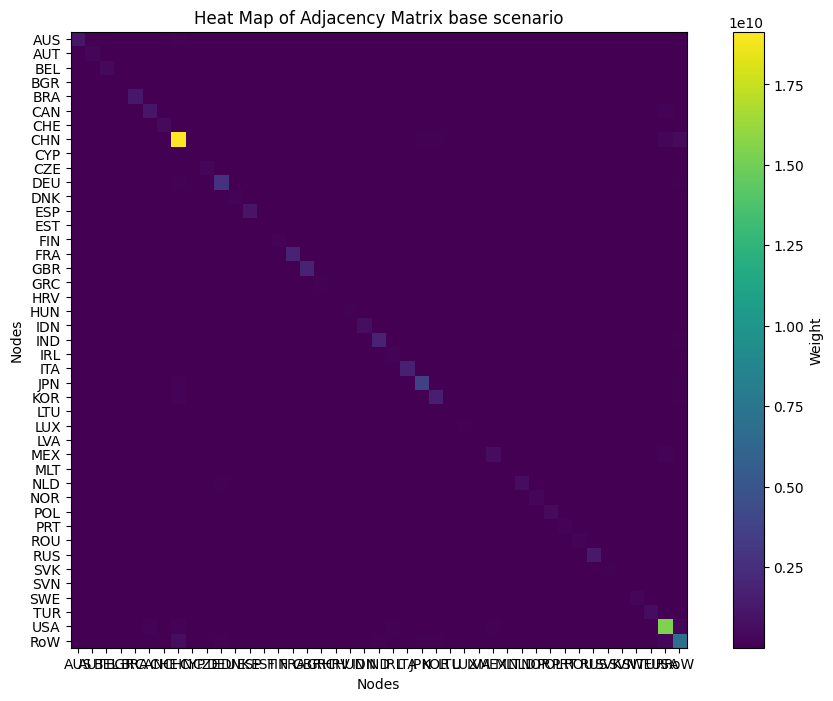

In [5]:
# Create a heat map of G_c
plt.figure(figsize=(12, 8))
plt.imshow(dfz_c, cmap='viridis', interpolation='none')
plt.colorbar(label='Weight')
plt.title('Heat Map of Adjacency Matrix base scenario')
plt.xlabel('Nodes')
plt.ylabel('Nodes')

# Add gridlines and node labels
plt.xticks(ticks=range(len(G_c.nodes)), labels=list(G_c.nodes))
plt.yticks(ticks=range(len(G_c.nodes)), labels=list(G_c.nodes))
#plt.grid(False)

plt.show()

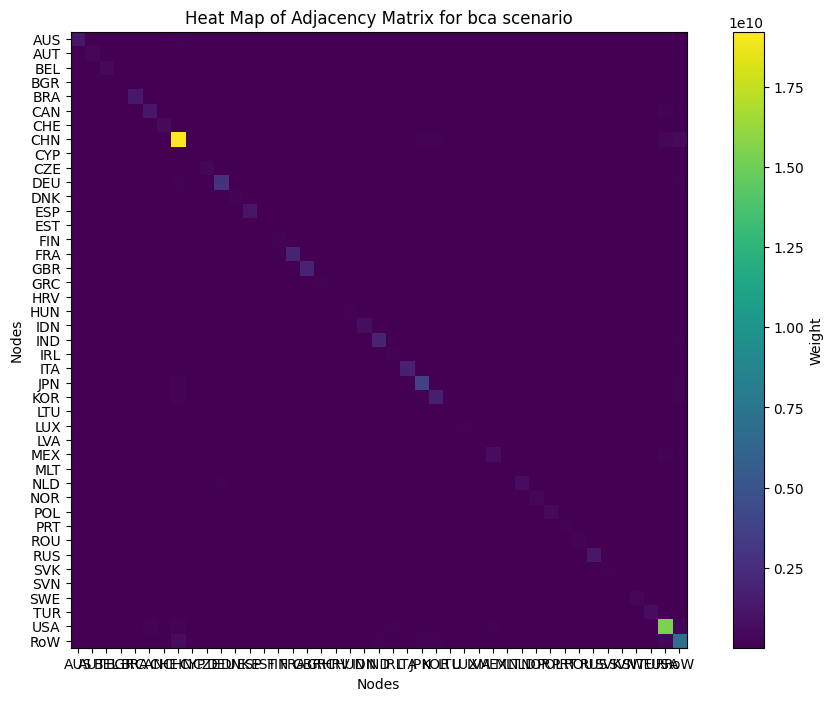

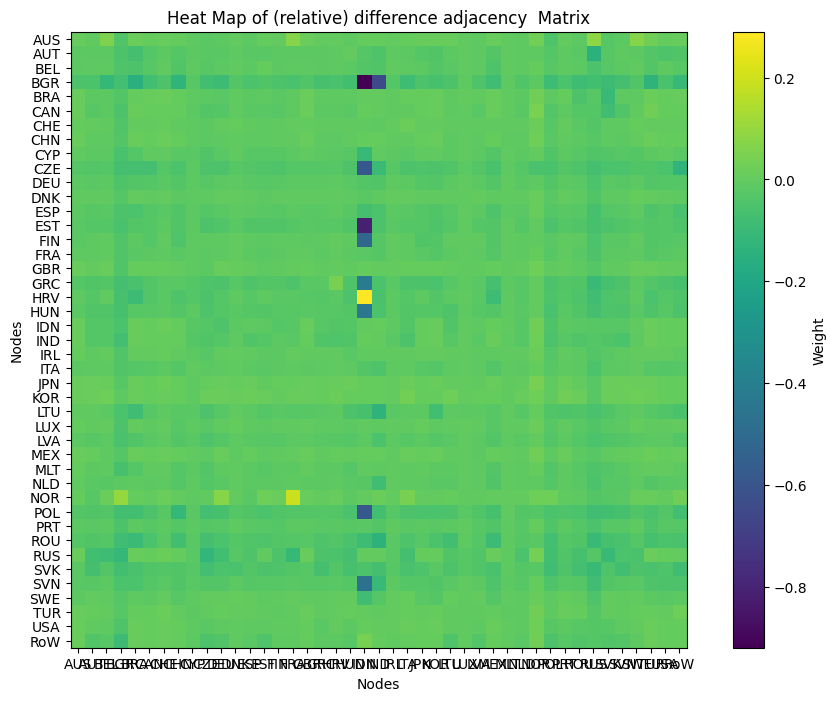

In [6]:
# Create a heat map of G_b_c
plt.figure(figsize=(12, 8))
plt.imshow(dfz_b_c, cmap='viridis', interpolation='none')
plt.colorbar(label='Weight')
plt.title('Heat Map of Adjacency Matrix for bca scenario')
plt.xlabel('Nodes')
plt.ylabel('Nodes')

# Add gridlines and node labels
plt.xticks(ticks=range(len(G_c.nodes)), labels=list(G_c.nodes))
plt.yticks(ticks=range(len(G_c.nodes)), labels=list(G_c.nodes))
#plt.grid(False)

plt.show()

#create an adjacency matrix equal to the relative difference of A_bca and A
df_dif_b = (dfz_b_c - dfz_c) / dfz_c
df_dif_b.head()

# Create a heat map
plt.figure(figsize=(12, 8))
plt.imshow(df_dif_b, cmap='viridis', interpolation='none')
plt.colorbar(label='Weight')
plt.title('Heat Map of (relative) difference adjacency  Matrix')
plt.xlabel('Nodes')
plt.ylabel('Nodes')

# Add gridlines and node labels
plt.xticks(ticks=range(len(G_c.nodes)), labels=list(G_c.nodes))
plt.yticks(ticks=range(len(G_c.nodes)), labels=list(G_c.nodes))
#plt.grid(False)

plt.show()

In [7]:
# Get in-degrees and out-degrees for each node
in_degrees = dict(G_b.in_degree())  # In-degree for each node
out_degrees = dict(G_b.out_degree())  # Out-degree for each node
# Convert the in-degrees and out-degrees to lists for easier computation
in_degree_values = list(in_degrees.values())
out_degree_values = list(out_degrees.values())

# Calculate mean and standard deviation for in-degree and out-degree
mean_in_degree = np.mean(in_degree_values)
std_in_degree = np.std(in_degree_values)

mean_out_degree = np.mean(out_degree_values)
std_out_degree = np.std(out_degree_values)

# Print the mean and standard deviation
print(f"In-Degree - Mean: {mean_in_degree}, Standard Deviation: {std_in_degree}")
print(f"Out-Degree - Mean: {mean_out_degree}, Standard Deviation: {std_out_degree}")

In-Degree - Mean: 2063.0, Standard Deviation: 0.0
Out-Degree - Mean: 2063.0, Standard Deviation: 0.0


In [8]:
#def a function to create cumulative dict for countries
def cum_count(D):
    cum_count_D = {}
    # Loop over each key in the original dictionary
    for key, value in D.items():
        # Extract the prefix (the part before the underscore)
        prefix = key.split('_')[0]
    
        # Sum the values for each prefix
        if prefix in cum_count_D:
            cum_count_D[prefix] += value
        else:
            cum_count_D[prefix] = value
    return cum_count_D

Weight - Mean: 19327.383724511426, Standard Deviation: 1236172.9579948445


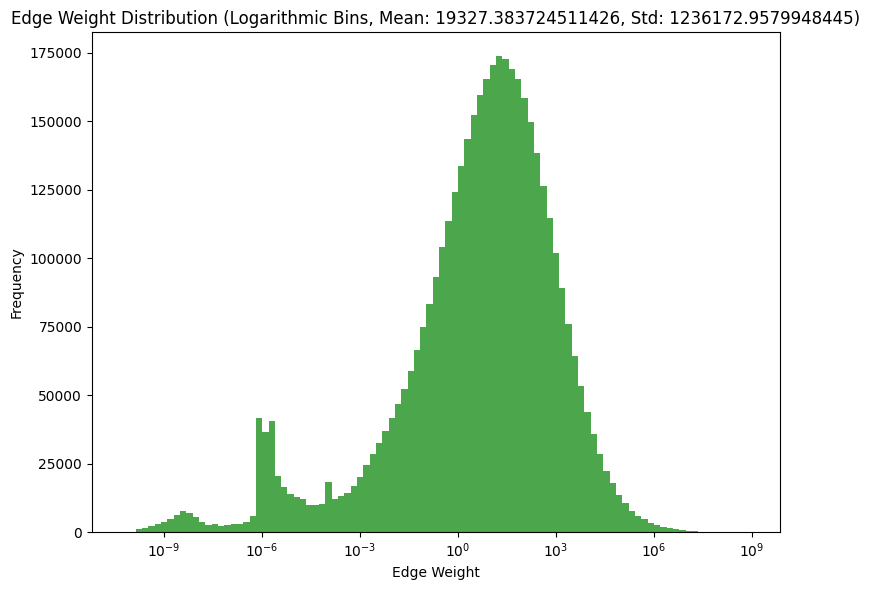

in_strength - Mean: 39872392.62366707, Standard Deviation: 134550988.60968366


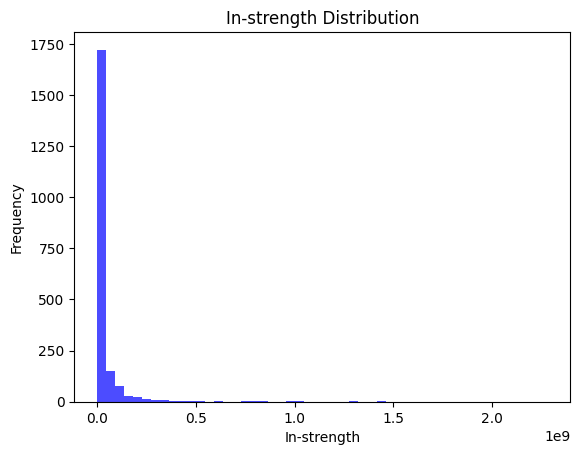

out_strength - Mean: 39872392.623667076, Standard Deviation: 140462305.9317053


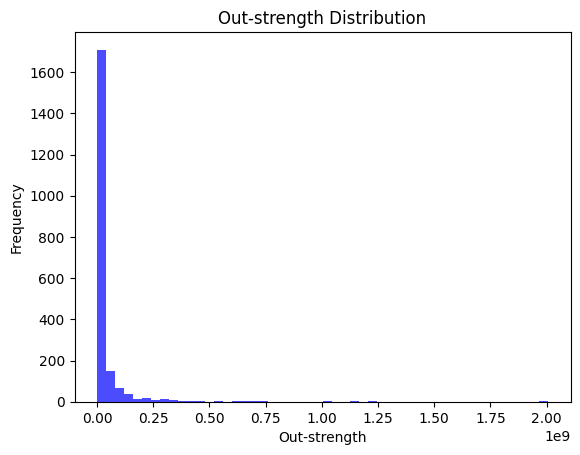

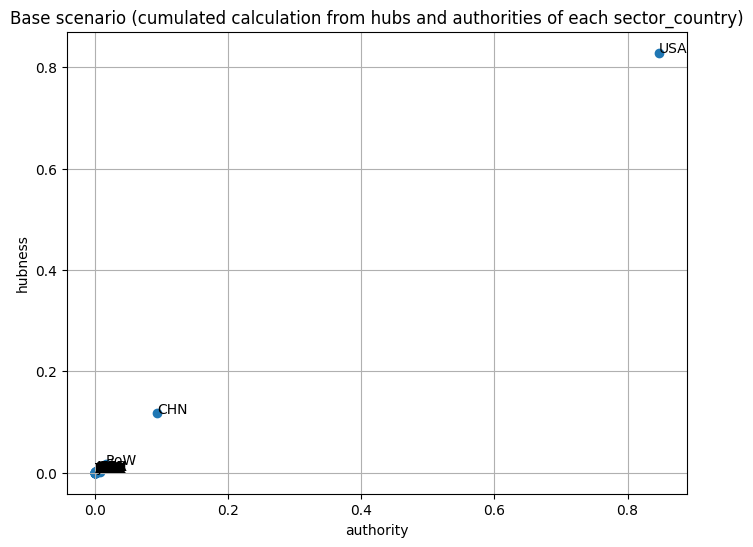

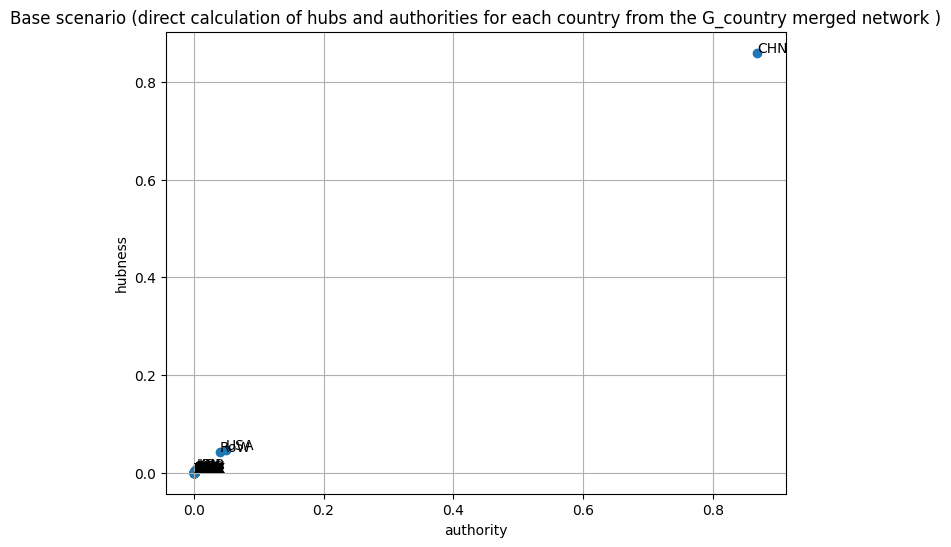

In [9]:
#centrality measures for Base

######## Weight ########
weights = dfz.values.flatten() # Flatten the matrix to extract the weights
mean_weight = np.mean(weights)
std_weight = np.std(weights)
print(f"Weight - Mean: {mean_weight}, Standard Deviation: {std_weight}")
# Plot with logarithmic bins
plt.figure(figsize=(8, 6))
plt.hist(weights, bins=np.logspace(np.log10(min(weights)), np.log10(max(weights)), 100), color='g', alpha=0.7)
plt.xscale('log')
plt.title(f'Edge Weight Distribution (Logarithmic Bins, Mean: {mean_weight}, Std: {std_weight})')
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show() 

######## In and Out strenght ########
in_str = {node: sum(data['weight'] for _, _, data in G.in_edges(node, data=True)) for node in G.nodes}
plt.hist(in_str.values(), bins = 50, color='b', alpha=0.7)
plt.title('In-strength Distribution')
plt.xlabel('In-strength') 
plt.ylabel('Frequency') 
in_str_val = list(in_str.values())
mean_in_str = np.mean(in_str_val)
std_in_str = np.std(in_str_val)
print(f"in_strength - Mean: {mean_in_str}, Standard Deviation: {std_in_str}")
plt.show()

out_str = {node: sum(data['weight'] for _, _, data in G.out_edges(node, data=True)) for node in G.nodes}
plt.hist(out_str.values(), bins = 50, color='b', alpha=0.7)
plt.title('Out-strength Distribution')
plt.xlabel('Out-strength') 
plt.ylabel('Frequency') 
out_str_val = list(out_str.values())
mean_out_str = np.mean(out_str_val)
std_out_str = np.std(out_str_val)
print(f"out_strength - Mean: {mean_out_str}, Standard Deviation: {std_out_str}")

######## Hubs and authorities ########
### from G ###
hub_aut = nx.hits(G)
hub_c= cum_count(hub_aut[0])
aut_c= cum_count(hub_aut[1])
keys = list(hub_c.keys()) 
aut_val = [aut_c[key] for key in keys] #x-axis
hub_val = [hub_c[key] for key in keys] #y-axis

plt.figure(figsize=(8, 6))
plt.scatter(aut_val, hub_val)

for i, key in enumerate(keys): # Annotate points with their labels
    plt.annotate(key, (aut_val[i], hub_val[i]))
# Set the range for x and y axes
#plt.xlim(0.0, 0.075) 
#plt.ylim(0.0, 0.08) 

plt.xlabel('authority')
plt.ylabel('hubness')
plt.title('Base scenario (cumulated calculation from hubs and authorities of each sector_country)')

# Display the plot
plt.grid(True)
plt.show()

### from G_c ###
hub_aut_c = nx.hits(G_c)
keys = list(hub_aut_c[1].keys()) 
val_aut = [hub_aut_c[1][key] for key in keys] #x-axis
val_hub = [hub_aut_c[0][key] for key in keys] #y-axis


# Plot
plt.figure(figsize=(8, 6))
plt.scatter(val_aut, val_hub)

# Annotate points with their labels
for i, key in enumerate(keys):
    plt.annotate(key, (val_aut[i], val_hub[i]))
# Set the range for x and y axes
#plt.xlim(0.0, 0.075) 
#plt.ylim(0.0, 0.08) 

# Label axes
plt.xlabel('authority')
plt.ylabel('hubness')
plt.title('Base scenario (direct calculation of hubs and authorities for each country from the G_country merged network )')

# Display the plot
plt.grid(True)
plt.show()

Weight - Mean: 19315.94847436987, Standard Deviation: 1240432.7242848594


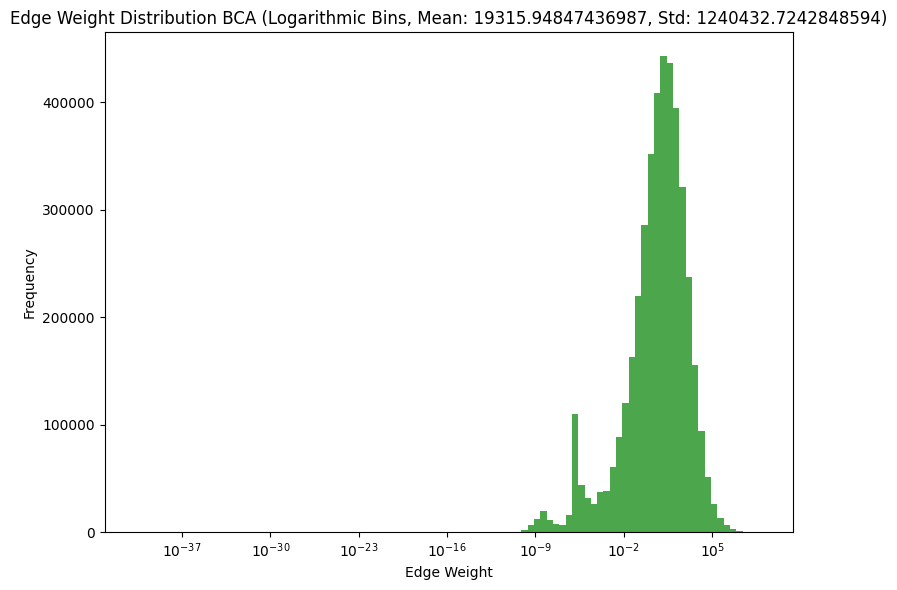

in_strength - Mean: 39848801.70262503, Standard Deviation: 134984817.2275121


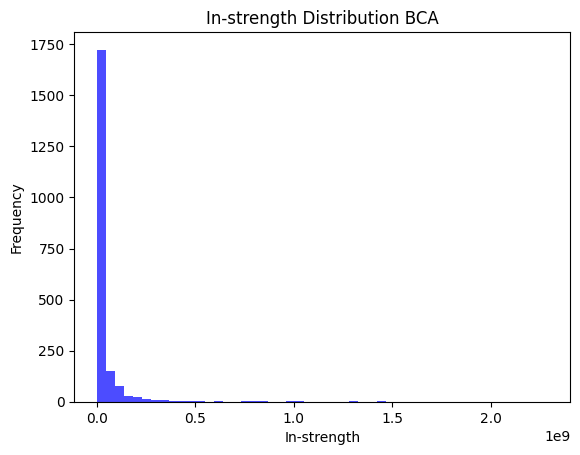

out_strength - Mean: 39848801.70262503, Standard Deviation: 140920163.90629598


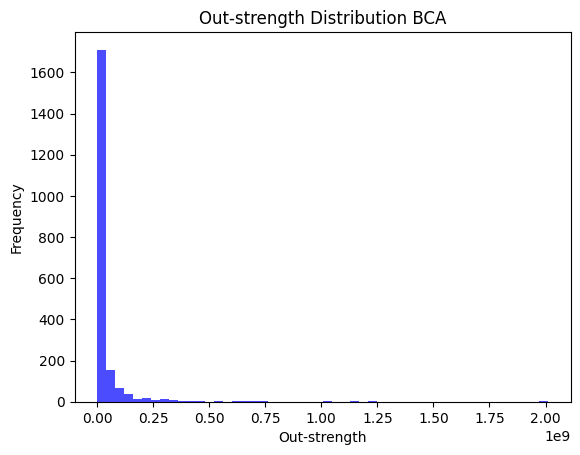

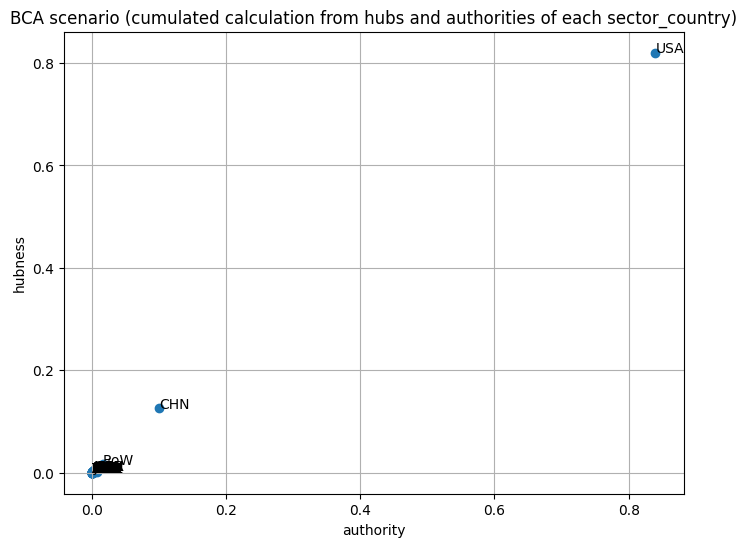

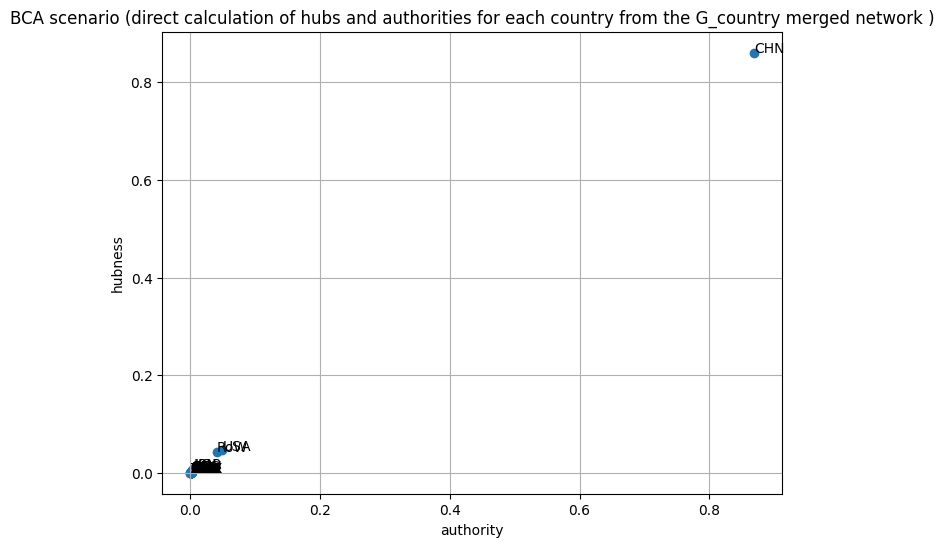

In [10]:
#centrality measures for BCA

######## Weight ########
weights = dfz_b.values.flatten() # Flatten the matrix to extract the weights
mean_weight = np.mean(weights)
std_weight = np.std(weights)
print(f"Weight - Mean: {mean_weight}, Standard Deviation: {std_weight}")
# Plot with logarithmic bins
plt.figure(figsize=(8, 6))
plt.hist(weights, bins=np.logspace(np.log10(min(weights)), np.log10(max(weights)), 100), color='g', alpha=0.7)
plt.xscale('log')
plt.title(f'Edge Weight Distribution BCA (Logarithmic Bins, Mean: {mean_weight}, Std: {std_weight})')
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show() 

######## In and Out strenght ########
in_str = {node: sum(data['weight'] for _, _, data in G_b.in_edges(node, data=True)) for node in G_b.nodes}
plt.hist(in_str.values(), bins = 50, color='b', alpha=0.7)
plt.title('In-strength Distribution BCA')
plt.xlabel('In-strength') 
plt.ylabel('Frequency') 
in_str_val = list(in_str.values())
mean_in_str = np.mean(in_str_val)
std_in_str = np.std(in_str_val)
print(f"in_strength - Mean: {mean_in_str}, Standard Deviation: {std_in_str}")
plt.show()

out_str = {node: sum(data['weight'] for _, _, data in G_b.out_edges(node, data=True)) for node in G_b.nodes}
plt.hist(out_str.values(), bins = 50, color='b', alpha=0.7)
plt.title('Out-strength Distribution BCA')
plt.xlabel('Out-strength') 
plt.ylabel('Frequency') 
out_str_val = list(out_str.values())
mean_out_str = np.mean(out_str_val)
std_out_str = np.std(out_str_val)
print(f"out_strength - Mean: {mean_out_str}, Standard Deviation: {std_out_str}")

######## Hubs and authorities ########
### from G_b ###
hub_aut_b = nx.hits(G_b)
hub_b_c= cum_count(hub_aut_b[0])
aut_b_c= cum_count(hub_aut_b[1])
keys = list(hub_c.keys()) 
aut_val = [aut_b_c[key] for key in keys] #x-axis
hub_val = [hub_b_c[key] for key in keys] #y-axis

plt.figure(figsize=(8, 6))
plt.scatter(aut_val, hub_val)

for i, key in enumerate(keys): # Annotate points with their labels
    plt.annotate(key, (aut_val[i], hub_val[i]))
# Set the range for x and y axes
#plt.xlim(0.0, 0.075) 
#plt.ylim(0.0, 0.08) 

plt.xlabel('authority')
plt.ylabel('hubness')
plt.title('BCA scenario (cumulated calculation from hubs and authorities of each sector_country)')

# Display the plot
plt.grid(True)
plt.show()

### from G_c_b ###
hub_aut_b_c = nx.hits(G_b_c)
keys = list(hub_aut_c[1].keys()) 
val_aut = [hub_aut_b_c[1][key] for key in keys] #x-axis
val_hub = [hub_aut_b_c[0][key] for key in keys] #y-axis


# Plot
plt.figure(figsize=(8, 6))
plt.scatter(val_aut, val_hub)

# Annotate points with their labels
for i, key in enumerate(keys):
    plt.annotate(key, (val_aut[i], val_hub[i]))
# Set the range for x and y axes
#plt.xlim(0.0, 0.075) 
#plt.ylim(0.0, 0.08) 

# Label axes
plt.xlabel('authority')
plt.ylabel('hubness')
plt.title('BCA scenario (direct calculation of hubs and authorities for each country from the G_country merged network )')

# Display the plot
plt.grid(True)
plt.show()

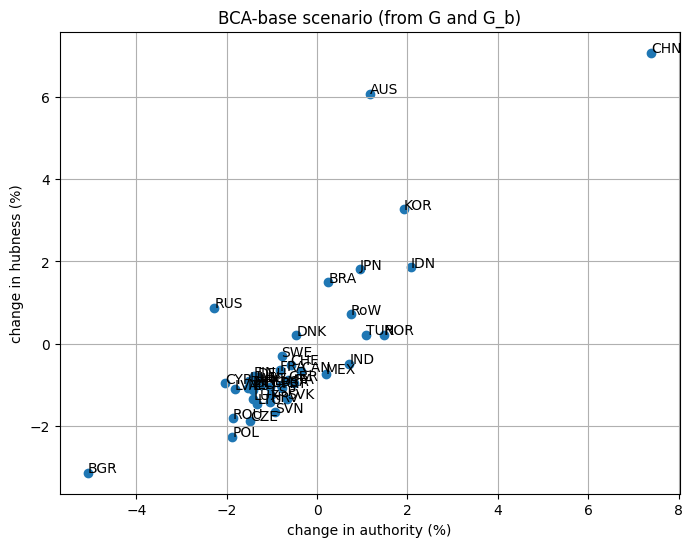

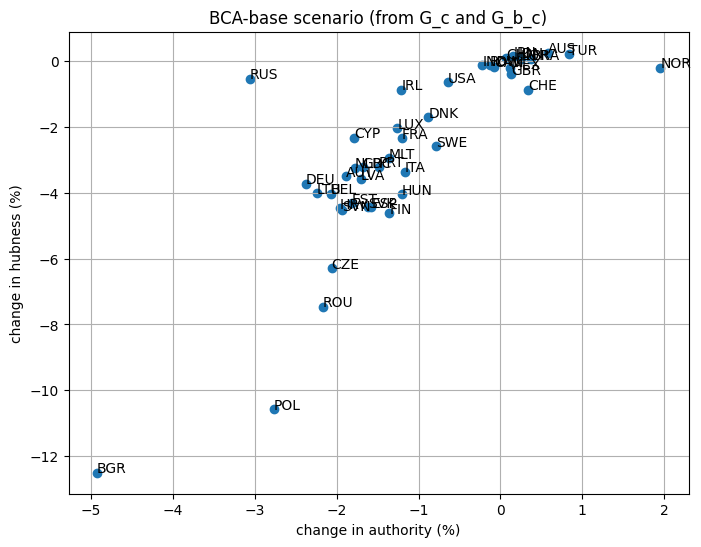

In [11]:
#compute the relative difference between hubs and authorities from G and G_b
diff_hub = {label: ((hub_b_c[label] - hub_c[label]) / hub_c[label])*100  for label in hub_c}
diff_aut = {label: ((aut_b_c[label] - aut_c[label]) / aut_c[label])*100  for label in aut_c}

# Plot
keys = list(diff_hub.keys()) 
values_author = [diff_aut[key] for key in keys] #x-axis
values_hubs = [diff_hub[key] for key in keys] #y-axis
plt.figure(figsize=(8, 6))
plt.scatter(values_author, values_hubs)

for i, key in enumerate(keys): # Annotate points with their labels
    plt.annotate(key, (values_author[i], values_hubs[i]))
    
plt.xlabel('change in authority (%)')
plt.ylabel('change in hubness (%)')
plt.title('BCA-base scenario (from G and G_b)')

plt.grid(True)
plt.show()

###############################################################################
#compute the relative difference between hubs and authorities from G_c and G_b_c
diff_hub_c = {label: ((hub_aut_b_c[0][label] - hub_aut_c[0][label]) / hub_aut_c[0][label])*100  for label in hub_aut_c[0]}
diff_aut_c = {label: ((hub_aut_b_c[1][label] - hub_aut_c[1][label]) / hub_aut_c[1][label])*100  for label in hub_aut_c[1]}

# Plot
keys = list(diff_hub_c.keys()) 
values_author = [diff_aut_c[key] for key in keys] #x-axis
values_hubs = [diff_hub_c[key] for key in keys] #y-axis
plt.figure(figsize=(8, 6))
plt.scatter(values_author, values_hubs)

for i, key in enumerate(keys): # Annotate points with their labels
    plt.annotate(key, (values_author[i], values_hubs[i]))
    
plt.xlabel('change in authority (%)')
plt.ylabel('change in hubness (%)')
plt.title('BCA-base scenario (from G_c and G_b_c)')

plt.grid(True)
plt.show()

In [12]:
def normalize_edge_weights(G):
    G_copy = G.copy()
    # Extract all edge weights
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    
    w_min, w_max = min(weights), max(weights)
    
    # Avoid division by zero if all weights are the same
    if w_max == w_min:
        return G_copy  # No need to normalize if all weights are identical
    
    # Normalize each edge weight in the copied graph
    for u, v in G_copy.edges():
        G_copy[u][v]['weight'] = (G_copy[u][v]['weight'] - w_min) / (w_max - w_min)
    
    return G_copy

In [13]:
def set_small_weights_to_zero(G, threshold):
    # Create a copy of the graph so that the original graph is not modified
    G_copy = G.copy()
    
    # Find edges with weight below threshold and remove them
    edges_to_remove = [(u, v) for u, v, data in G_copy.edges(data=True) if data['weight'] < threshold]
    G_copy.remove_edges_from(edges_to_remove)
    
    return G_copy

In [14]:
G_norm= normalize_edge_weights(G)

In [15]:
G_spar = set_small_weights_to_zero(G_norm, threshold=1e-6)

In [16]:
G_no_loo = G_spar.copy() 
G_no_loo.remove_edges_from(nx.selfloop_edges(G_no_loo))  # Remove self-loops from the copy
density = nx.density(G_no_loo)
print(f"Graph Density: {density:.15f}")
#compute clustering coeff (3100 seconds for 450000 edges )


Graph Density: 0.138201690399365


In [17]:
clus_coeff = nx.clustering(G_spar, weight='weight')
print(f"Clustering Coefficient: {clus_coeff}")

KeyboardInterrupt: 

In [46]:
import networkx as nx

def sparsify_3pct_by_sector_inflow(G, weight_key='weight'):
    """
    Create a new DiGraph H where, for each buyer node v,
    we group its in-edges by the *supplier sector* and keep
    only those edges >= 3% of the total inflow from that sector.

    Assumes each node name looks like 'COUNTRY_SECTOR',
    e.g. 'FRA_MANche' or 'CHN_MANche'.
    """
    H = nx.DiGraph()

    # Iterate over each "buyer" node v
    for v in G.nodes():
        in_edges_data = G.in_edges(v, data=True)

        # 1) Sum flows by supplier sector
        sector_in_sum = {}
        for (u, _, data) in in_edges_data:
            w = data.get(weight_key, 0.0)
            # Parse the supplier node's sector
            try:
                supplier_country, supplier_sector = u.split('_', 1)
            except ValueError:
                # If node naming doesn't match the pattern, skip or handle differently
                continue
            
            sector_in_sum.setdefault(supplier_sector, 0.0)
            sector_in_sum[supplier_sector] += w

        # 2) Keep edges above 3% threshold for each supplier sector
        for (u, _, data) in in_edges_data:
            w = data.get(weight_key, 0.0)
            try:
                supplier_country, supplier_sector = u.split('_', 1)
            except ValueError:
                continue

            total_for_sector = sector_in_sum.get(supplier_sector, 0.0)
            if total_for_sector > 0 and w >= 0.03 * total_for_sector:
                # Add this edge to H if it meets the criterion
                H.add_edge(u, v, **{weight_key: w})

    return H


# -----------------------------
# EXAMPLE USAGE
# -----------------------------
if __name__ == "__main__":
    import pandas as pd
    
    # 1) Load your adjacency matrix from a parquet file (example: 'dfz.parquet')
    dfz = pd.read_parquet('dfz.parquet')

    # 2) Build a directed graph from the adjacency matrix
    G = nx.from_pandas_adjacency(dfz, create_using=nx.DiGraph)

    # 3) Apply the sector-based 3% inflow sparsification
    H = sparsify_3pct_by_sector_inflow(G, weight_key='weight')

    # 4) Convert the new graph H back to a DataFrame if you wish
    dfz_sparsified = nx.to_pandas_adjacency(H, dtype=float)
    dfz_sparsified.to_parquet('dfz_sparsified.parquet')

    # Check how many edges remain
    print(f"Original graph edges: {G.number_of_edges()}")
    print(f"Sparsified graph edges: {H.number_of_edges()}")

Original graph edges: 4255969
Sparsified graph edges: 341154
